# Path integral Monte Carlo
The programme implements the path integral Monte Carlo procedure to diagonalize the anharmonic oscillator, whose path integral is given by:

$$
\left<x_f\left|\ e^{-iHt}\ \right|x_i\right>\ =\int_{x(0)=x_i}^{x(t)=x_f} \mathcal{D}x\ e^{iS[x]}\qquad\qquad
S[x]=\int_0^t dt\left[\frac{1}{4}\dot{x}^2-\left(x^2-\eta^2\right)^2\right]
$$

Input parameters, with default values:
- potential parameters: $\lambda=1$, $\eta=1.4$
- mass of the particle: $m=0.5$
- number of lattice points: $N=800$
- lattice spacing: $a=0.05$
- number of Metropolis configurations: $N_{sweeps}=100$
- number of sweeps between each measurement: $N_{cor}=20$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
import math
import random
from tqdm.notebook import tqdm

In [2]:
# Parameters of the potential
Lambda = float(input("lambda = ") or 1);
eta = float(input("eta = ") or 1.4);
m = float(input("m = ") or 1/2);
hbar = 1;

lambda = 
eta = 
m = 


In [3]:
# Lattice parameters
N = int(input("N = ") or 800);
a = float(input("a = ") or 0.05);
Nsweeps = int(input("Nsweeps = ") or 100);
Ncor = int(input("Ncorrelation = ") or 20)

N = 
a = 
Nsweeps = 
Ncorrelation = 


## Exact diagonalization
We repeat here the exact diagonalization procedure, which will be used for comparison in the following.

In [4]:
Ngrid = int(input("Ngrid = ") or 800);
xmin = float(input("xmin = ") or -3);
xmax = float(input("xmax = ") or 3);

# Potential
xvec = np.linspace(xmin, xmax, Ngrid);     # Vector spanning from xmin to xmax with Ngrid points
Vx = Lambda*(xvec**2-eta**2)**2;

# Kinetic energy discretization
dx = np.diff(xvec).mean();     # Grid resolution
diag = -2*np.ones(Ngrid);      # -2f(x)
offdiag = np.ones(Ngrid-1);    # f(x+dx) and f(x-dx)

d2grid = np.mat(np.diag(diag,0) + np.diag(offdiag,-1) + np.diag(offdiag,1))/dx**2;     # Discretized second derivative

# Avoid problems at the edge of the grid
d2grid[0,:] = 0;
d2grid[Ngrid-1,:] = 0;

Ekin = -hbar**2/(2*m)*d2grid;

# Potential energy discretization
Epot = np.mat(np.diag(Vx, 0))

# Total Hamiltonian diagonalization
H = Ekin + Epot;
w, v = LA.eig(H);

sortinds = np.argsort(w);     # Returns the indices that would sort the array w
EigVals = w[sortinds];        # Eigenvalues sorting
EigVecs = v[:,sortinds];      # Corresponding eigenvectors sorting

Ngrid = 
xmin = 
xmax = 


## Monte Carlo method

### Evaluating the action
The action in euclidean time $\beta=it$ is given by:

$$
S_E[x]=\int_0^\beta d\tau \left[\frac{1}{4}\dot{x}^2+\left(x^2-\eta^2\right)^2\right]
$$

We discretize the euclidean time coordinate as: $\tau_j=ja$, with $j=1,\dots,N$, so that the action becomes:

$$
S=\sum_{j=1}^N \left[\frac{1}{4a}\left(x_j-x_{j-1}\right)^2+a\left(x_j^2-\eta^2\right)^2\right]
$$

where $x_j\equiv x(\tau_j)$. Since only few terms of the action change when $x_j$ is updated in the Metropolis algorithm, the following function computes only these terms, as $\Delta S = S'-S = S'_j-S_j$ when $x_j$ is changed, where we denote by $S_j$ the action with only $x_j$-dependent terms, and the prime means updated:

$$
S_j=\frac{1}{4a}\left[\left(x_j-x_{j-1}\right)^2+\left(x_{j+1}-x_j\right)^2\right]+a\left(x_j^2-\eta^2\right)^2
$$

In [5]:
# Function that evaluates the action of a given configuration considering only j-dependent terms
def S(j,x):
    if j == N-1:
        Action = ((x[j]-x[j-1])**2 + (x[0]-x[j])**2)/(4*a) + a*(x[j]**2-eta**2)**2;       # Periodic boundary conditions
    else:
        Action = ((x[j]-x[j-1])**2 + (x[j+1]-x[j])**2)/(4*a) + a*(x[j]**2-eta**2)**2;
    return Action

### Initial configuration
We can choose wether to start with a cold configuration $\{x_i\}^{(0)}=\{0\}$ or with a hot one $\{x_i\}^{(0)}=\{r_i\}$, where $r_i$ is a random variable.

In [16]:
# Generating the initial configuration
x = np.zeros(N);

while True:
    choice = input("Type C for cold start, H for hot start: ")
    if choice == "C":                          # Cold start configuration
        break
    elif choice == "H":
        for i in range(N):
            x[i] = x[i] + random.random();     # Hot start configuration
        break

Type C for cold start, H for hot start: C


### Metropolis algorithm
The Metropolis method generates an ensemble of configurations $\{x_i\}^{(k)}$, where $i=1,\dots,N$ labels the lattice points and $k=1,\dots,N_{sweeps}$ the various configurations. The configurations are generated via a trial update $x_i^{(k+1)}=x_i^{(k)}+\delta x$ performed for every lattice site, where $\delta x$ is for instance a Gaussian random number with the width of the distribution $\varepsilon$ adjusted such that the average acceptance rate for the trial updates is around $50\%$. The trial update is accepted with probability:

$$
P\left(x_i^{(k)}\rightarrow x_i^{(k+1)}\right)=\mbox{min}\left\{e^{-\Delta S}, 1\right\}
$$

A similar algorithm can be used to find the nearest classical solution to a given quantum one (the so called $\textit{instanton solution}$), by accepting only the updates that lower the action, $\Delta S<0$.

In [7]:
eps = float(input("epsilon = ") or 0.5);

# Function that updates x according to Metropolis algorithm
def update(x):
    for j in range(N):
        old_x = x[j];                                    # Save the original values
        old_Sj = S(j,x);
        x[j] = x[j] + random.gauss(0, eps);              # Update x[j]
        dS = S(j,x) - old_Sj;                            # Change in action
        if math.exp(-dS) < random.random():              # Metropolis acceptance criterium
            x[j] = old_x;                                # Restore the old value in case the condition is not satisfied
            
# Function that updates x cooling the system
def cooling(x):
    for j in range(N):
        old_x = x[j];                                    # Save the original values
        old_Sj = S(j,x);
        x[j] = x[j] + random.gauss(0, eps);              # Update x[j]
        dS = S(j,x) - old_Sj;                            # Change in action
        if dS > 0:                                       # Cooling condition
            x[j] = old_x;                                # Restore the old value in case the condition is not satisfied

epsilon = 


#### Sample path
The following code returns an example of euclidean path, obtained after $N_{path}=500$ thermalization sweeps; the path is then cooled through $N_{cool}=100$ thermalization sweeps.

Npath = 
Ncool = 


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

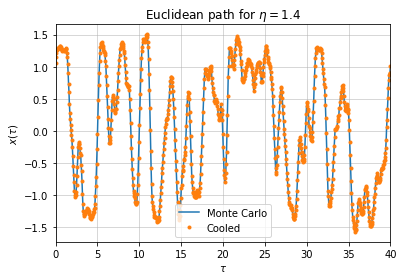

In [8]:
Npath = int(input("Npath = ") or 500);

def Path(x):
    for j in tqdm(range(Npath)):
        update(x)
    return x

Ncool = int(input("Ncool = ") or 100);

def CooledPath(x):
    for j in tqdm(range(Ncool)):           # Cooling the path with Ncool steps
        cooling(x)
    return x

x = Path(x);
x_cooled = CooledPath(x);
tau_vec = np.linspace(0, N*a, N);          # Total euclidean time obtained from lattice spacing a and from N

fig, ax = plt.subplots()
ax.plot(tau_vec, x, label = 'Monte Carlo');
ax.plot(tau_vec, x_cooled, '.', label = 'Cooled');
ax.set_xlabel('$\\tau$');
ax.set_ylabel('$x(\\tau)$');
plt.xlim([0, 40])
plt.grid(linewidth=0.5);
plt.title('Euclidean path for $\eta =$'+str(eta));
plt.legend()
plt.show()

We see that for small $\tau$ the system is controlled by the oscillation time $\tau_{osc}$, while for large $\tau$ it is governed by the tunneling time $\tau_{tun}$. We can estimate:
$$
\tau_{osc}\sim \frac{1}{4\eta}\qquad\mbox{and}\qquad \tau_{tun}\sim \mbox{exp}\left(-\frac{4}{3}\eta^3\right)
$$
and in order to have a reliable simulation we should check that the lattice spacing is small compared to $\tau_{osc}$ and the total length of the lattice $Na$ is much larger than the tunneling time:
$$
a\ll \tau_{osc}\qquad\mbox{and}\qquad \tau_{tun}\ll Na
$$
In our case we have:

In [9]:
print("a = " + str(a) + "           tau_osc = " + str(round(1/(4*eta), 3)))
print("tau_tun = " + str(round(math.exp(-4*eta**3/3), 3)) + "    N*a = " + str(N*a))

a = 0.05           tau_osc = 0.179
tau_tun = 0.026    N*a = 40.0


### Correlation functions
The two point correlation function of order $t$ is defined as follows:

$$
G_t^{(2)}(x, \Delta\tau)\equiv \langle [x(\tau)]^t [x(\tau+\Delta\tau)]^t\rangle \approx \frac{1}{N}\sum_{i=1}^N \sum_{j\in J}x_i^t x_j^t
$$

where $J=\left\{j: 0\leq j\leq N, j-i=\Delta\tau\ \mbox{mod } N\right\}$ and $x_i = x(\tau_i)$, $\tau_i = i\Delta\tau$. In the following we will consider $t=1, 2, \dots, N_{cf}$ with $N_{cf}=3$ by default. Quantum mechanical averages are computed by averaging observables over many configurations:

$$
\langle\mathcal{O}\rangle = \lim_{N_{config}\to \infty}\frac{1}{N_{config}}\sum_{k=1}^{N_{config}}\mathcal{O}^{(k)}
$$

The method allows to estimate the error in the measurement of $\left<\mathcal{O}\right>$ from statistical fluctuations, under the assumption that the different configurations are statistically independent (which is to be verified by computing the auto-correlation time in successive measurements, and can be tuned by $N_{cor}$):

$$
\Delta\left<\mathcal{O}\right>=\sqrt{\frac{\left<\mathcal{O}^2\right>-\left<\mathcal{O}\right>^2}{N_{sweeps}}}
$$

We will therefore need to compute the mean value $\left<\mathcal{O}\right>$ as well, and to consider one-point correlation functions as well:

$$
G_t^{(1)}(x)\equiv \langle [x(\tau)]^t \rangle \approx \frac{1}{N}\sum_{i=1}^N x_i^t
$$

In [18]:
Ncf = int(input("N of correlation functions = ") or 3);

# Function that computes the two-point correlation function of order t
def computeG2(x, dtau, t):
    g = 0;                                     # Initialize the value of the correlation function
    for j in range(N):
        g = g + (x[j]**t)*(x[(j+dtau)%N]**t);  # Add all the terms satisfying the above condition for J
    return g/N

# Function that computes the Monte Carlo average
def MCaverage(x):
    G = np.zeros((Nsweeps, N, Ncf))            # Initialize the value of the two-point correlation function
    G1 = np.zeros((Nsweeps, N, Ncf))           # Initialize the value of the one-point correlation function
    
    for j in range(5*Ncor):                    # Initial thermalization
        update(x)
    for k in tqdm(range(Nsweeps)):
        for j in range(Ncor):                  # Thermalization steps between each measurement
            update(x)
        for t in range(Ncf):                   # Evaluate correlation functions of order t = 1, 2, ..., Ncf
            for n in range(N):
                G[k, n, t] = computeG2(x, n, t+1);
                G1[k, n, t] = x[n]**t;

    avg_G = np.zeros((N, Ncf));                # Initialize the value of the average
    avg_G1 = avg_G;                            # (both for one- and two-point correlation functions)
    
    for n in range(N):                         # Compute the Monte Carlo average for each order t
        for t in range(Ncf):
            for k in range(Nsweeps):
                avg_G[n, t] = avg_G[n, t] + G[k, n, t];          # Second-order correlation function
                avg_G1[n, t] = avg_G1[n, t] + G1[k, n, t];       # First-order correlation function
    avg_G = avg_G / Nsweeps;
    avg_G1 = avg_G1 / Nsweeps;
        
    return [avg_G, avg_G1]


# Computing the first Ncf correlation functions
[G_two, G_one] = MCaverage(x)

deltaG = np.sqrt(np.abs(G_two-np.power(G_one, 2)) / Nsweeps);          # Statistical error

N of correlation functions = 


  0%|          | 0/100 [00:00<?, ?it/s]

#### Comparison with exact diagonalization
The correlation functions can be also computed using exact diagonalization, in order to see wether the two different methods give the same result. Letting $O(\tau)=x(\tau)^t$, we have that the two-point correlation functions $G_t^{(2)}(x,\tau)=\left<O(0)O(\tau)\right>$ can be computed by inserting a complete set of states in the expectation value:

$$
G_t^{(2)}(x,\tau)=\sum_{n}\left|\left<0|O(0)|n\right>\right|^2\ e^{-(E_n-E_0)\tau}
$$

In [51]:
def ComputeG_exact(x):
    G_exact = np.zeros((N, Ncf));

    for n in range(10):
        for t in range(Ncf):
            for i in range(N):
                G_exact[i, t] = G_exact[i, t] + (x[0]**t)**2 * np.exp(-np.abs(EigVals[n]-EigVals[0])*tau_vec[i]);
                
    return G_exact

G_exact = ComputeG_exact(x);

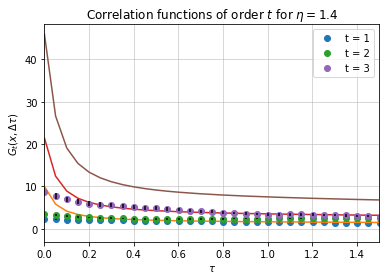

In [52]:
# Plotting the correlation functions
fig, ax = plt.subplots()

for i in range(Ncf):
    ax.plot(tau_vec, G_two[:,i], 'o', label = 't = '+str(i+1))
    plt.errorbar(tau_vec, G_two[:,i], yerr = deltaG[:,i], xerr = None, fmt = 'None', ecolor = 'black')
    
    ax. plot(tau_vec, G_exact[:,i])

ax.set_xlabel('$\\tau$');
ax.set_ylabel('$G_t(x,\Delta\\tau)$');
plt.xlim([0, 1.5]);
plt.grid(linewidth=0.5);
plt.title('Correlation functions of order $t$ for $\eta =$'+str(eta));
plt.legend()
plt.show()

#### Probability distribution
The probability distribution $|\psi(x)|^2$ computed exactly via diagonalization can be compared with the number of counts coming from the Monte Carlo simulation, upon scaling one of the two by a factor of $N$.

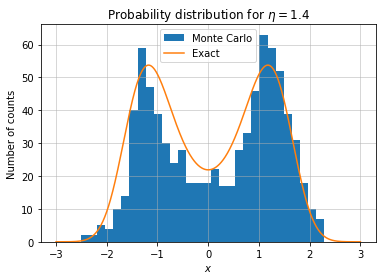

In [19]:
psi_squared = np.power(np.abs(EigVecs[:,0]), 2)            # Computing the square modulus of the wavefunction
norm = np.sum(EigVecs[:,0])                                # Normalization

fig, ax = plt.subplots()
ax.hist(x, 30, label = 'Monte Carlo');
ax.plot(xvec, N*norm*psi_squared, label = 'Exact')         # Exact result from diagonalization, for comparison
ax.set_xlabel('$x$');
ax.set_ylabel('Number of counts');
plt.grid(linewidth=0.5);
plt.title('Probability distribution for $\eta =$'+str(eta));
plt.legend()
plt.show()

#### Logarithmic derivative of the correlation function


In [54]:
%load_ext watermark

# python, ipython, packages, and machine characteristics
%watermark -v -m -p matplotlib,numpy,math,random,tqdm 

# date
print (" ")
%watermark -u -n -t -z 

Python implementation: CPython
Python version       : 3.10.2
IPython version      : 8.4.0

matplotlib: 3.5.2
numpy     : 1.22.2
math      : unknown
random    : unknown
tqdm      : 4.64.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 69 Stepping 1, GenuineIntel
CPU cores   : 4
Architecture: 64bit

 
Last updated: Fri Aug 12 2022 12:36:31ora legale Europa occidentale

